In [1]:
import pandas as pd
import numpy as np

import os
import pathlib

import cv2 #영상처리에 사용하는 오픈소스 라이브러리, 컴퓨터가 사람 눈처럼 인식할 수 있게 처리
from PIL import Image # 파이썬 이미지 처리 pillow 라이브러리
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator #imagedatagenerater는 이미지를 학습시킬 때 학습 데이터의 양이 적을 경우 학습데이터를 조금씩 변형 시켜서 학습데이터의 양을 늘리는 방식중 하나
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

#난수 랜덤성 고정
np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB

/content/drive/.shortcut-targets-by-id/1WKEjdIyqtzI-NV5o0O_ixsHslngaSiQX/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB


Train Data 불러오기

In [4]:
import numpy as np
import os
import gzip
import urllib.request

from keras.models import load_model

def ordered_onehotencoding(labels):
    labels_ordered = []
    for i in range(len(labels)):
        if labels[i] == 3:
            labels_ordered.append(0)
        elif labels[i] == 7:
            labels_ordered.append(1)
        elif labels[i] == 9:
            labels_ordered.append(2)
        elif labels[i] == 10:
            labels_ordered.append(3)
        elif labels[i] == 11:
            labels_ordered.append(4)
        elif labels[i] == 12:
            labels_ordered.append(5)
        elif labels[i] == 13:
            labels_ordered.append(6)
        elif labels[i] == 17:
            labels_ordered.append(7)
        elif labels[i] == 18:
            labels_ordered.append(8)
        elif labels[i] == 25:
            labels_ordered.append(9)
        elif labels[i] == 35:
            labels_ordered.append(10)
        elif labels[i] == 38:
            labels_ordered.append(11)
    
    return np.array(labels_ordered)

class GTSRB:
    def __init__(self):
        imgs_path = "Train"
        data_list = []
        labels_list = []

        result_class = [3,7, 9, 10, 11, 12, 13, 17, 18, 25, 35, 38]

        for i in result_class:
            i_path = os.path.join(imgs_path, str(i)) # 3, 7, 9, 10, 11, 12,13, 17, 18, 25, 35, 38
            num = 0
            for img in os.listdir(i_path):
          
                im = Image.open(i_path +'/'+ img)
                im = im.resize((32,32))
                im = np.array(im)

                data_list.append(im)
                labels_list.append(i)
                num = num + 1
                if num == 1000:
                    break;

        data = np.array(data_list)
        labels = ordered_onehotencoding(labels_list)

        labels = to_categorical(labels)

        VALIDATION_SIZE = 5000
        
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(np.array(data), labels, test_size=0.4)    

    @staticmethod
    def print():
        return "GTSRB"

In [5]:
data = GTSRB()

In [6]:
print(data.x_train.shape)
print(data.x_test.shape)
print(data.y_train.shape)
print(data.y_test.shape)

(7200, 32, 32, 3)
(4800, 32, 32, 3)
(7200, 12)
(4800, 12)


Test Data 불러오기

In [7]:
metainfo = pd.read_csv("Meta.csv")
traininfo = pd.read_csv("Train.csv")
testinfo = pd.read_csv("Test.csv")

In [8]:
import natsort

class GTSRB_test:
    def __init__(self):
        imgs_path = "Test"
        data_list = []
        labels_list = []
        
        for img in natsort.natsorted(os.listdir(imgs_path)):
            im = Image.open(imgs_path +'/'+ img)
            im = im.resize((32,32))
            im = np.array(im)
            data_list.append(im)
        data_test = np.array(data_list)
        
        for i in range(len(testinfo.ClassId)):
            labels_list.append(testinfo.ClassId[i])
        
        labels_test = np.array(labels_list)

        labels_test_index = []
        for i in range(len(labels_test)):
            if (labels_test[i] == 3) | (labels_test[i] == 7) | (labels_test[i] == 9) | (labels_test[i] == 10) | (labels_test[i] == 11) | (labels_test[i] == 12) | (labels_test[i] == 13) | (labels_test[i] == 17) | (labels_test[i] == 18) | (labels_test[i] == 25) | (labels_test[i] == 35) | (labels_test[i] == 38):
                labels_test_index.append(i)

        test_data = []
        test_label = []
        for i in labels_test_index:
            test_data.append(data_test[i])
            test_label.append(labels_test[i])

        data_test = np.array(test_data)

        labels_test =ordered_onehotencoding(test_label)

        labels_test = to_categorical(labels_test)
        
        self.x_test = data_test
        self.y_test = labels_test    

    @staticmethod
    def print():
        return "GTSRB_test"

In [9]:
data_test = GTSRB_test()

In [10]:
print(data_test.x_test.shape)
print(data_test.y_test.shape)

(6180, 32, 32, 3)
(6180, 12)


### 분류기 : CNN

In [11]:
data.x_train, data.y_train, data.x_test, data.y_test =data.x_train/255, data.y_train/255, data.x_test/255, data.y_test/255

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import os


def train(data, file_name, num_epochs=50, batch_size=128):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    IMG_HEIGHT = 32
    IMG_WIDTH = 32

    # 첫번째 Convolutional Layer : 입력 데이터로부터 특징을 추출
    model.add(Conv2D(filters=96, kernel_size=3, activation='relu', input_shape=data.x_train.shape[1:]))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    # 두번째 Convolutional Layer
    model.add(Conv2D(filters=192, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25)) # 인풋데이터의 25%를 무작위로 0으로 만듦

    # 세번째 Convolutional Layer
    model.add(Conv2D(filters=192, kernel_size=3, activation='relu')) # 특징을 추출하는 기능을 하는 필터, 비선형 값으로 바꿔주는 activation 함수->relu
    # model.add(GlobalAveragePooling2D())
    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(12, activation='softmax'))


    # 모델 컴파일 하기
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    # 모델 핏하기
    EPOCHS = num_epochs
    model.fit(data.x_train, data.y_train,
              validation_data = (data.x_test, data.y_test), 
              epochs=EPOCHS, steps_per_epoch=60
              )

    if file_name != None:
        model.save(file_name)

    return model


if not os.path.isdir('models'):
    os.makedirs('models')

model = train(data, "models/gtsrb_classifier", num_epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 192)       166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 192)         0

In [13]:
loss, accuracy = model.evaluate(data.x_train, data.y_train)

print('test set accuracy: ', accuracy * 100)

loss, accuracy = model.evaluate(data.x_test, data.y_test)

print('test set accuracy: ', accuracy * 100)

225/225 [==============================] - 1s 3ms/step - loss: 0.0024 - accuracy: 0.9597
test set accuracy:  95.97222208976746
150/150 [==============================] - 0s 3ms/step - loss: 0.0024 - accuracy: 0.9535
test set accuracy:  95.35416960716248


In [14]:
# test data set
loss, accuracy = model.evaluate(data_test.x_test, data_test.y_test)

print('test set accuracy: ', accuracy * 100)

# --> 애초에 오버피팅 되어있음을 확인할 수 있다.

loss, accuracy = model.evaluate(data_test.x_test/255, data_test.y_test/255)

print('test set accuracy with nomalization: ', accuracy * 100)

# --> /255로 정규화 시켜준다면 어느정도 성능 회복 

194/194 [==============================] - 1s 4ms/step - loss: 34.6723 - accuracy: 0.8523
test set accuracy:  85.22653579711914
194/194 [==============================] - 1s 4ms/step - loss: 0.0024 - accuracy: 0.8903
test set accuracy with nomalization:  89.02912735939026


### FGSM 
epsilon = 0.02로 FGSM Attack을 가해주겠다

In [ ]:
def tf_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (32, 32))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_tf_label(labels):
    label = tf.cast(labels, tf.int32)
    label = tf.reshape(label,[1,12])
    return label

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    input_img = tf.reshape(input_image,[1,32,32,3])
    prediction = model(input_img)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

def fgsm_attack(model,test_x,test_y,eps):
    
    correct = 0
    adv_examples = []
    save_adv_examples = []
    save_original_output = []
    
    for i in range(len(test_x)):
        data = test_x[i]
        target = test_y[i]

        result = model.predict(data.reshape(1,32,32,3) / 255)
        init_output = int(np.argmax(result))
 
        if init_output != np.argmax(target):
            continue

        img =  tf_preprocess(data)
        label = get_tf_label(target)
        
        perturbations = create_adversarial_pattern(img, label)

        adv_x = img + eps*perturbations
        adv_x = tf.clip_by_value(adv_x, 0, 1)


        output = model.predict(adv_x)

        final_pred = int(np.argmax(output))

        if final_pred == int(np.argmax(target)):
            correct += 1
            if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))
        else:
            if len(adv_examples) < 5:
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))

        save_adv_examples.append(tf.reshape(adv_x,[32,32,3]))
        save_original_output.append(init_output)


    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_x), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_adv_examples, save_original_output

In [ ]:
eps = 0.02

accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
acc, ex, ad_examples, orig_labels = fgsm_attack(model, data_test.x_test, data_test.y_test, eps) # 9 min

Epsilon: 0.02	Test Accuracy = 2626 / 6180 = 0.4249190938511327


In [ ]:
ad_examples1 = np.array(ad_examples) # 이미 정규화되어서 나온 값으로 추가적인 /255 정규화 필요 없음
orig_labels1 = to_categorical(orig_labels)

print(ad_examples1.shape)
print(orig_labels1.shape)

(5318, 32, 32, 3)
(5318, 12)


In [ ]:
loss, accuracy = model.evaluate(ad_examples1, orig_labels1)

print('test(not train) set attacked accuracy: ', accuracy * 100)

167/167 [==============================] - 1s 5ms/step - loss: 0.5732 - accuracy: 0.4938
test(not train) set attacked accuracy:  49.379464983940125


###  Defense Model 1 : DefenseGAN

In [32]:
import numpy as np
import os
import gzip
import urllib.request

from keras.models import load_model

def ordered_onehotencoding(labels):
    labels_ordered = []
    for i in range(len(labels)):
        if labels[i] == 3:
            labels_ordered.append(0)
        elif labels[i] == 7:
            labels_ordered.append(1)
        elif labels[i] == 9:
            labels_ordered.append(2)
        elif labels[i] == 10:
            labels_ordered.append(3)
        elif labels[i] == 11:
            labels_ordered.append(4)
        elif labels[i] == 12:
            labels_ordered.append(5)
        elif labels[i] == 13:
            labels_ordered.append(6)
        elif labels[i] == 17:
            labels_ordered.append(7)
        elif labels[i] == 18:
            labels_ordered.append(8)
        elif labels[i] == 25:
            labels_ordered.append(9)
        elif labels[i] == 35:
            labels_ordered.append(10)
        elif labels[i] == 38:
            labels_ordered.append(11)
    
    return np.array(labels_ordered)

class GTSRB_defenseGAN:
    def __init__(self):
        imgs_path = "Train"
        data_list = []
        labels_list = []

        result_class = [3,7, 9, 10, 11, 12, 13, 17, 18, 25, 35, 38]

        for i in result_class:
            i_path = os.path.join(imgs_path, str(i)) # 3, 7, 9, 10, 11, 12,13, 17, 18, 25, 35, 38
            num = 0
            for img in os.listdir(i_path):
          
                im = Image.open(i_path +'/'+ img)
                im = im.resize((32,32))
                im = np.array(im)

                data_list.append(im)
                labels_list.append(i)
                num = num + 1
                if num == 1000:
                    break;

        data = np.array(data_list)
        labels = ordered_onehotencoding(labels_list)

        labels = to_categorical(labels)

        VALIDATION_SIZE = 5000
        
        data = (data.astype(np.float32) - 127.5) / 127.5 #모든 데이터 픽셀 값을 -1~1로 피팅 시킨다 (GAN 학습을 위함)
        
        self.x_train = np.array(data)
        self.y_train = labels

    @staticmethod
    def print():
        return "GTSRB_defenseGAN"

In [33]:
data_train_GAN = GTSRB_defenseGAN()

In [34]:
print(data_train_GAN.x_train.shape)
print(data_train_GAN.y_train.shape)

(12000, 32, 32, 3)
(12000, 12)


GAN 생성

In [35]:
import numpy as np 
import matplotlib.pyplot as plt 

from keras.datasets import mnist

from keras.models import Sequential, Model

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D

from tensorflow.keras.optimizers import Adam

noise_data = np.random.normal(0, 1, (32, 100))
#generated_images = 0.5 * generator.predict(np.random.normal(0, 1, (32, 100))) + 0.5

def show_images(generated_images, n=4, m=8, figsize=(9, 5)):
    f, axes = plt.subplots(n, m, figsize=figsize)
    #plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
    for i in range(0, n):
        for j in range(0, m):
            ax = axes[i][j]
            ax.imshow(generated_images[i * m + j])
            ax.grid(False)
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
    plt.tight_layout()
    plt.savefig('20220729_basicgan.svg')
    plt.show()   
#show_images(0.5 * generator.predict(np.random.normal(0, 1, (32, 100))) + 0.5)


## create generator         
generator_ = Sequential([
    Dense(128 * 8 * 8, activation="relu", input_shape=(100,)), 
    Reshape((8, 8, 128)), 
    
    BatchNormalization(momentum=0.8), # what is batch normalization?? 
    UpSampling2D(), # what is upsampling?? 
    Conv2D(128, kernel_size=3, padding="same"),
    Activation("relu"), 
    
    BatchNormalization(momentum=0.8), 
    UpSampling2D(), 
    Conv2D(64, kernel_size=3, padding="same"), 
    Activation("relu"), 
    
    BatchNormalization(momentum=0.8), 
    Conv2D(3, kernel_size=3, padding="same"), 
    Activation("tanh"), 
])

noise_input = Input(shape=(100,), name="noise_input")
generator_base = Model(noise_input, generator_(noise_input), name="generator")

generator_.summary()# summary가 매우 유용하군요. 

optimizer = Adam(0.0002, 0.5)
generator_base.compile(loss='binary_crossentropy', optimizer=optimizer)

### create discriminator
discriminator_ = Sequential([
    Conv2D(32, kernel_size=3, strides=2, input_shape=(32, 32, 3), padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    
    Conv2D(64, kernel_size=3, strides=2, padding="same"), 
    ZeroPadding2D(padding=((0,1),(0,1))), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    BatchNormalization(momentum=0.8), 
    
    Conv2D(128, kernel_size=3, strides=2, padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    BatchNormalization(momentum=0.8), 
    
    Conv2D(256, kernel_size=3, strides=1, padding="same"), 
    LeakyReLU(alpha=0.2), 
    Dropout(0.25), 
    Flatten(), 
    Dense(1, activation='sigmoid'), 
])
image_input = Input(shape=(32, 32, 3), name="image_input")

discriminator = Model(image_input, discriminator_(image_input), name="discriminator")
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator_.summary()

### Combined Model
noise_input2 = Input(shape=(100,), name="noise_input2")
"""
model과 sequential의 차이는?? 
가설1: 레이어를 쌓는 것이 sequential 이라면, sequential을 쌓는 것이 model인가???

1) 다음 모델의 경우는 랜덤으로 만든 이미지로부터 학습해서 새로운 이미지를 만들어내는 generator의 데이터를 
2) discriminator가 분류하는 형식으로 진행된다. 
"""
combined = Model(noise_input2, discriminator(generator_base(noise_input2)))
combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 128)        512       
 ormalization)                                                   
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 activation (Activation)     (None, 16, 16, 128)      

In [36]:
## training
"""
- 이 코드에서는 fit을 사용한 것이 아니라, train_on_batch를 사용했음. 
- train_on_batch와의 차이점?을 구글에 검색해보니, 큰 차이가 없다고 하긴 하는데
    - train_on_batch의 경우, 넘겨 받은 데이터에 대해서 gradient vector를 계산해서 적용하고 끝내는 것이고(1epoch)
    - fit의 경우는 epoch과 batch_size를 한번에 모두 넘겨준다는 것 정도가 차이가 된다. 
- GAN의 경우, discriminator의 학습시 마다 generator가 생성하는 데이터가 변화하게 된다. 
    - 즉 처음부터 모든 데이터가 존재하고 이를 한번에 학습시키는 fit과는 다르게, 한번씩 업데이트를 할때마다 모델이 변화하므로, 
    - train_on_batch를 사용하는 것이 매우 합당함.
"""
batch_size = 256
half_batch = batch_size // 2

def train(epochs, print_step=10):
    history = []
    for epoch in range(epochs):
        # discriminator 트레이닝 단계
        #######################################################################3
        # 데이터 절반은 실제 이미지, 절반은 generator가 생성한 가짜 이미지
        # discriminator가 실제 이미지와 가짜 이미지를 구별하도록 discriminator를 트레이닝
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(data_train_GAN.x_train[np.random.randint(0, data_train_GAN.x_train.shape[0], half_batch)], 
                                                   np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(generator_base.predict(np.random.normal(0, 1, (half_batch, 100))), 
                                                   np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # generator 트레이닝 단계
        #######################################################################3
        # 전부 generator가 생성한 가짜 이미지를 사용. 
        # discriminator가 구별하지 못하도록 generator를 트레이닝
        
        """
        generator를 트레이닝할 때는, 반드시 discriminator가 필요함. 
        generator가 만든 image를 평가해야 하고, 그래야 feedback이 생겨서 generator가 학습됨. 
        따라서, generator는 combined model을 통해 학습시키는데, 이때, discriminator도 함께 학습되면 안되기 때문에
        discriminator.trainable 을 False로 변경시켜 둔다. 
        """
        noise = np.random.normal(0, 1, (batch_size, 100))
        discriminator.trainable = False 
        g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))  #여기서는 왜 만들어준 fake img의 y 값을 1로 두는 걸까 ..
        # 기록
        record = (epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1])
        history.append(record)
        if epoch % print_step == 0:
            print("%5d [D loss: %.3f, acc.: %.2f%%] [G loss: %.3f, acc.: %.2f%%]" % record)
            show_images(0.5 * generator_base.predict(noise_data) + 0.5)
    return history
#%%time, 은
history100 = train(20000, 500)
show_images(0.5 * generator_base.predict(noise_data) + 0.5)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
# GAN 모델 저장
from keras.models import load_model

generator_base.save('baseGAN_Generator_attacked0.02.h5')

DefenseGAN 구현 - FGSM

In [47]:
ad_example_data = ad_examples1 #/255로 이미 정규화가 된 이미지이다
orig_label_data = orig_labels1

print(ad_example_data.shape)
print(orig_label_data.shape)

NameError: ignored

In [ ]:
def DefenseGAN(img_at,L,R):
    z_list = []
    img = img_at.reshape(32,32,3)
    img_st = (img - np.mean(img)) / np.std(img) 
    img_var = tf.Variable(img_st,dtype = float)
    opt = tf.keras.optimizers.SGD(learning_rate=0.1,momentum = 0.7)

    def compute():
        z_hats_recs = generator_base(z_var)
        z_hats_recs = tf.reshape(z_hats_recs, [32,32,3])
        num_dim = len(z_hats_recs.get_shape())
        axes = range(1, num_dim)
        image_rec_loss = tf.reduce_mean(tf.square(z_hats_recs - img_var),axis=axes)
        rec_loss = tf.reduce_sum(image_rec_loss)
        return rec_loss

    for r in range(R):
        z = np.random.normal(0, 1, (1, 100))
        z_var = tf.Variable(z,dtype = float)
    
        for l in range(L):
            opt.minimize(compute,[z_var])
        z_list.append(z_var)

    def compute_10(z):
        #generator_base.trainable = False #아직 더해야하는지 뺴야하는지 판단 x
        z_hats_recs = generator_base(z)
        z_hats_recs = tf.reshape(z_hats_recs, [32,32,3])
        num_dim = len(z_hats_recs.get_shape())
        axes = range(1, num_dim)
        image_rec_loss = tf.reduce_mean(tf.square(z_hats_recs - img_var),axis=axes)
        rec_loss = tf.reduce_sum(image_rec_loss)
        return rec_loss
    

    loss_list = []
    
    for i in range(len(z_list)):
        loss = compute_10(z_list[i])
        loss_list.append(loss)
    
    index_min = np.argmin(loss_list)

    z_min = np.array(z_list[index_min])

    generated_images = 0.5 * generator_base.predict(z_min)+ 0.5

    generated_images = generated_images.reshape(32,32,3)

    return generated_images

In [ ]:
## predict_output에 한개씩 넣는 것부터 구현해야한다. (전체가 들어가는 것만 정상 작동함)

def test(classifier, ad_example_data, orig_label_data):

    # 정확도 카운터
    correct = 0
    defense_correct = 0
    df_examples = []
    # 테스트 셋의 모든 예제에 대해 루프를 돕니다

    loss, accuracy = classifier.evaluate(ad_examples1, orig_labels1)

    print('방어 전 모델 정확도 : ',accuracy * 100)

    for i in range(len(ad_example_data)):
        data = ad_example_data[i].reshape(-1,32,32,3)
        target = orig_label_data[i]
        
        data_plot = data.reshape(32,32,3)
        print('원본 label : ',np.argmax(target))
        plt.imshow(data_plot)
        plt.show();

        generated_img = DefenseGAN(data.reshape(32,32,3),200,10).reshape(-1,32,32,3)

        generated_img_plot = generated_img.reshape(32,32,3)


        defense_output = classifier.predict(generated_img.reshape(1,32,32,3))

        defense_pred= int(np.argmax(defense_output))

        print('방어 라벨 : ',defense_pred)
        plt.imshow(generated_img_plot)
        plt.show();

        if defense_pred == int(np.argmax(target)):
            defense_correct += 1
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))
        else:
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))

        print('Working...!')


    defense_acc = defense_correct / float(len(ad_example_data))
    print("Defense Accuracy = {} / {} = {}".format(defense_correct, len(ad_example_data), defense_acc))
    # 정확도와 적대적 예제를 리턴합니다
    return defense_acc, df_examples

In [ ]:
accuracies_df = []
examples_df = []

acc_df, ex_df = test(model, ad_example_data[:100], orig_label_data[:100])

accuracies_df.append(acc_df)
examples_df.append(ex_df)

Output hidden; open in https://colab.research.google.com to view.

### Defense 2 : PCA (Components = 5)

In [ ]:
ad_example_data = ad_examples1 #/255로 이미 정규화가 된 이미지이다
orig_label_data = orig_labels1

print(ad_example_data.shape)
print(orig_label_data.shape)

In [ ]:
from sklearn.decomposition import PCA

# data shape이 32,32,3이어야한다.
def defense_PCA(data,component):
    #r,g,b를 각각 나눠준다
    data = data.reshape(32,32,3)
    r = data[:,:,0]
    g = data[:,:,1]
    b = data[:,:,2]

    pca_r = PCA(n_components=component)
    pca_r_trans = pca_r.fit_transform(r)

    pca_g = PCA(n_components=component)
    pca_g_trans = pca_g.fit_transform(g)

    pca_b = PCA(n_components=component)
    pca_b_trans = pca_b.fit_transform(b)

    pca_r_org = pca_r.inverse_transform(pca_r_trans)
    pca_g_org = pca_g.inverse_transform(pca_g_trans)
    pca_b_org = pca_b.inverse_transform(pca_b_trans)

    img_compressed = np.stack((pca_r_org, pca_g_org, pca_b_org),axis = 2)

    return img_compressed.reshape((-1,32,32,3))

In [ ]:
## predict_output에 한개씩 넣는 것부터 구현해야한다. (전체가 들어가는 것만 정상 작동함)

def test(classifier, ad_example_data, orig_label_data):

    # 정확도 카운터
    correct = 0
    defense_correct = 0
    df_examples = []
    # 테스트 셋의 모든 예제에 대해 루프를 돕니다

    loss, accuracy = classifier.evaluate(ad_examples1, orig_labels1)

    print('방어 전 모델 정확도 : ',accuracy * 100)

    for i in range(len(ad_example_data)):
        data = ad_example_data[i].reshape(-1,32,32,3)
        target = orig_label_data[i]
        
        data_plot = data.reshape(32,32,3)
        print('원본 label : ',np.argmax(target))
        plt.imshow(data_plot)
        plt.show();

        generated_img = defense_PCA(data,5)

        generated_img_plot = generated_img.reshape(32,32,3)

        defense_output = classifier.predict(generated_img.reshape(1,32,32,3))

        defense_pred= int(np.argmax(defense_output))

        print('방어 라벨 : ',defense_pred)
        plt.imshow(generated_img_plot)
        plt.show();

        if defense_pred == int(np.argmax(target)):
            defense_correct += 1
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))
        else:
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))

        print('Working...!')


    defense_acc = defense_correct / float(len(ad_example_data))
    print("Defense Accuracy = {} / {} = {}".format(defense_correct, len(ad_example_data), defense_acc))
    # 정확도와 적대적 예제를 리턴합니다
    return defense_acc, df_examples

In [ ]:
accuracies_df = []
examples_df = []

acc_df, ex_df = test(model, ad_example_data, orig_label_data)

accuracies_df.append(acc_df)
examples_df.append(ex_df)

Output hidden; open in https://colab.research.google.com to view.

### Defense 2 : PCA (Components = 10)

In [ ]:
ad_example_data = ad_examples1 #/255로 이미 정규화가 된 이미지이다
orig_label_data = orig_labels1

print(ad_example_data.shape)
print(orig_label_data.shape)

(5318, 32, 32, 3)
(5318, 12)


In [ ]:
from sklearn.decomposition import PCA

# data shape이 32,32,3이어야한다.
def defense_PCA(data,component):
    #r,g,b를 각각 나눠준다
    data = data.reshape(32,32,3)
    r = data[:,:,0]
    g = data[:,:,1]
    b = data[:,:,2]

    pca_r = PCA(n_components=component)
    pca_r_trans = pca_r.fit_transform(r)

    pca_g = PCA(n_components=component)
    pca_g_trans = pca_g.fit_transform(g)

    pca_b = PCA(n_components=component)
    pca_b_trans = pca_b.fit_transform(b)

    pca_r_org = pca_r.inverse_transform(pca_r_trans)
    pca_g_org = pca_g.inverse_transform(pca_g_trans)
    pca_b_org = pca_b.inverse_transform(pca_b_trans)

    img_compressed = np.stack((pca_r_org, pca_g_org, pca_b_org),axis = 2)

    return img_compressed.reshape((-1,32,32,3))

In [ ]:
## predict_output에 한개씩 넣는 것부터 구현해야한다. (전체가 들어가는 것만 정상 작동함)

def test(classifier, ad_example_data, orig_label_data):

    # 정확도 카운터
    correct = 0
    defense_correct = 0
    df_examples = []
    # 테스트 셋의 모든 예제에 대해 루프를 돕니다

    loss, accuracy = classifier.evaluate(ad_examples1, orig_labels1)

    print('방어 전 모델 정확도 : ',accuracy * 100)

    for i in range(len(ad_example_data)):
        data = ad_example_data[i].reshape(-1,32,32,3)
        target = orig_label_data[i]
        
        data_plot = data.reshape(32,32,3)
        print('원본 label : ',np.argmax(target))
        plt.imshow(data_plot)
        plt.show();

        generated_img = defense_PCA(data,10)

        generated_img_plot = generated_img.reshape(32,32,3)

        defense_output = classifier.predict(generated_img.reshape(1,32,32,3))

        defense_pred= int(np.argmax(defense_output))

        print('방어 라벨 : ',defense_pred)
        plt.imshow(generated_img_plot)
        plt.show();

        if defense_pred == int(np.argmax(target)):
            defense_correct += 1
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))
        else:
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))

        print('Working...!')


    defense_acc = defense_correct / float(len(ad_example_data))
    print("Defense Accuracy = {} / {} = {}".format(defense_correct, len(ad_example_data), defense_acc))
    # 정확도와 적대적 예제를 리턴합니다
    return defense_acc, df_examples

In [ ]:
accuracies_df = []
examples_df = []

acc_df, ex_df = test(model, ad_example_data, orig_label_data)

accuracies_df.append(acc_df)
examples_df.append(ex_df)

Output hidden; open in https://colab.research.google.com to view.

### BIM

Basic Iteration Model를 통해 공격데이터를 생성하겠다

In [15]:
data.x_train, data.y_train, data.x_test, data.y_test
print('train x 데이터 : ',data.x_train.shape)
print('train y 데이터 : ',data.y_train.shape)
print('test x 데이터 : ',data.x_test.shape)
print('test y 데이터 : ',data.y_test.shape)

train x 데이터 :  (7200, 32, 32, 3)
train y 데이터 :  (7200, 12)
test x 데이터 :  (4800, 32, 32, 3)
test y 데이터 :  (4800, 12)


In [16]:
# real test data
print(data_test.x_test.shape)
print(data_test.y_test.shape)

(6180, 32, 32, 3)
(6180, 12)


In [17]:
iterations = 7
alpha = 2
epsilon = 8/255

In [20]:
def tf_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (32, 32))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_tf_label(labels):
    label = tf.cast(labels, tf.int32)
    label = tf.reshape(label,[1,12])
    return label

loss_object = tf.keras.losses.CategoricalCrossentropy()

def pgd_attack(model,test_x,test_y,alpha,iterations,epsilon):
    
    correct = 0
    adv_examples = []
    save_adv_examples = []
    save_original_output = []
    
    for i in range(len(test_x)):
        data = test_x[i]
        target = test_y[i]

        result = model.predict(data.reshape(1,32,32,3) / 255)
        init_output = int(np.argmax(result))
 
        if init_output != np.argmax(target):
            continue

        img =  tf_preprocess(data)
        label = get_tf_label(target)

        gen_img = img + tf.random.uniform(img.get_shape().as_list(), minval=-epsilon, maxval=+epsilon, dtype=tf.dtypes.float32)

        for iters in range(iterations):
            imgv = tf.Variable(gen_img)
            with tf.GradientTape() as tape:
                tape.watch(imgv)
                predictions = model(imgv)
                loss = tf.keras.losses.CategoricalCrossentropy()(label, predictions)
            grads = tape.gradient(loss,imgv)
            signed_grads = tf.sign(grads)
            gen_img = gen_img + (alpha  * signed_grads)
            gen_img = tf.clip_by_value(gen_img, img-epsilon, img+epsilon)

        adv_x = gen_img

        output = model.predict(adv_x)

        final_pred = int(np.argmax(output))

        if final_pred == int(np.argmax(target)):
            correct += 1
            if (len(adv_examples) < 5):
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))
        else:
            if len(adv_examples) < 5:
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))

        save_adv_examples.append(tf.reshape(adv_x,[32,32,3]))
        save_original_output.append(init_output)


    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x))
    print("PGD: Test Accuracy = {} / {} = {}".format(correct, len(test_x), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_adv_examples, save_original_output

In [21]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
acc, ex, ad_examples, orig_labels = pgd_attack(model, data_test.x_test, data_test.y_test, alpha,iterations,epsilon) # 9 min

PGD: Test Accuracy = 1535 / 6180 = 0.2483818770226537


In [25]:
ad_examples_BIM = np.array(ad_examples) # 이미 정규화되어서 나온 값으로 추가적인 /255 정규화 필요 없음
orig_labels_BIM = to_categorical(orig_labels)

print(ad_examples_BIM.shape)
print(orig_labels_BIM.shape)

(5502, 32, 32, 3)
(5502, 12)


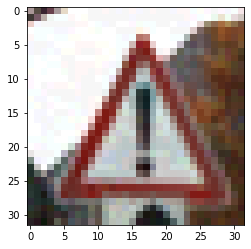

In [26]:
plt.imshow(ad_examples_BIM[3])

In [27]:
loss, accuracy = model.evaluate(ad_examples_BIM, orig_labels_BIM)

print('test(not train) set attacked accuracy: ', accuracy * 100)

172/172 [==============================] - 2s 9ms/step - loss: 0.6844 - accuracy: 0.2790
test(not train) set attacked accuracy:  27.898946404457092


### DefenseGAN 구현 - BIM



In [28]:
ad_examples_BIM = np.array(ad_examples) # 이미 정규화되어서 나온 값으로 추가적인 /255 정규화 필요 없음
orig_labels_BIM = to_categorical(orig_labels)

print(ad_examples_BIM.shape)
print(orig_labels_BIM.shape)

(5502, 32, 32, 3)
(5502, 12)


In [33]:
# GAN 모델 저장
from keras.models import load_model

generator_base = load_model('baseGAN_Generator_attacked0.02.h5')

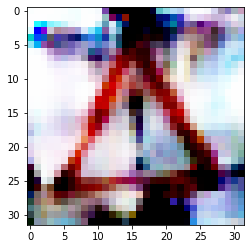

In [41]:
plt.imshow(generator_base.predict(np.random.normal(0, 1, (1, 100))).reshape(32,32,3))

In [42]:
def DefenseGAN(img_at,L,R):
    z_list = []
    img = img_at.reshape(32,32,3)
    img_st = (img - np.mean(img)) / np.std(img) 
    img_var = tf.Variable(img_st,dtype = float)
    opt = tf.keras.optimizers.SGD(learning_rate=0.1,momentum = 0.7)

    def compute():
        z_hats_recs = generator_base(z_var)
        z_hats_recs = tf.reshape(z_hats_recs, [32,32,3])
        num_dim = len(z_hats_recs.get_shape())
        axes = range(1, num_dim)
        image_rec_loss = tf.reduce_mean(tf.square(z_hats_recs - img_var),axis=axes)
        rec_loss = tf.reduce_sum(image_rec_loss)
        return rec_loss

    for r in range(R):
        z = np.random.normal(0, 1, (1, 100))
        z_var = tf.Variable(z,dtype = float)
    
        for l in range(L):
            opt.minimize(compute,[z_var])
        z_list.append(z_var)

    def compute_10(z):
        #generator_base.trainable = False #아직 더해야하는지 뺴야하는지 판단 x
        z_hats_recs = generator_base(z)
        z_hats_recs = tf.reshape(z_hats_recs, [32,32,3])
        num_dim = len(z_hats_recs.get_shape())
        axes = range(1, num_dim)
        image_rec_loss = tf.reduce_mean(tf.square(z_hats_recs - img_var),axis=axes)
        rec_loss = tf.reduce_sum(image_rec_loss)
        return rec_loss
    

    loss_list = []
    
    for i in range(len(z_list)):
        loss = compute_10(z_list[i])
        loss_list.append(loss)
    
    index_min = np.argmin(loss_list)

    z_min = np.array(z_list[index_min])

    generated_images = 0.5 * generator_base.predict(z_min)+ 0.5

    generated_images = generated_images.reshape(32,32,3)

    return generated_images

In [43]:
## predict_output에 한개씩 넣는 것부터 구현해야한다. (전체가 들어가는 것만 정상 작동함)

def test(classifier, ad_example_data, orig_label_data):

    # 정확도 카운터
    correct = 0
    defense_correct = 0
    df_examples = []
    # 테스트 셋의 모든 예제에 대해 루프를 돕니다

    loss, accuracy = classifier.evaluate(ad_example_data, orig_label_data)

    print('방어 전 모델 정확도 : ',accuracy * 100)

    for i in range(len(ad_example_data)):
        data = ad_example_data[i].reshape(-1,32,32,3)
        target = orig_label_data[i]
        
        data_plot = data.reshape(32,32,3)
        print('원본 label : ',np.argmax(target))
        plt.imshow(data_plot)
        plt.show();

        generated_img = DefenseGAN(data.reshape(32,32,3),200,10).reshape(-1,32,32,3)

        generated_img_plot = generated_img.reshape(32,32,3)


        defense_output = classifier.predict(generated_img.reshape(1,32,32,3))

        defense_pred= int(np.argmax(defense_output))

        print('방어 라벨 : ',defense_pred)
        plt.imshow(generated_img_plot)
        plt.show();

        if defense_pred == int(np.argmax(target)):
            defense_correct += 1
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))
        else:
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))

        print('Working...!')


    defense_acc = defense_correct / float(len(ad_example_data))
    print("Defense Accuracy = {} / {} = {}".format(defense_correct, len(ad_example_data), defense_acc))
    # 정확도와 적대적 예제를 리턴합니다
    return defense_acc, df_examples

In [44]:
accuracies_df = []
examples_df = []

acc_df, ex_df = test(model, ad_examples_BIM[:100], orig_labels_BIM[:100])

accuracies_df.append(acc_df)
examples_df.append(ex_df)

Output hidden; open in https://colab.research.google.com to view.

### Defense 2 : PCA (Components = 5)

In [47]:
ad_examples_BIM = np.array(ad_examples) # 이미 정규화되어서 나온 값으로 추가적인 /255 정규화 필요 없음
orig_labels_BIM = to_categorical(orig_labels)

print(ad_examples_BIM.shape)
print(orig_labels_BIM.shape)

from sklearn.decomposition import PCA

# data shape이 32,32,3이어야한다.
def defense_PCA(data,component):
    #r,g,b를 각각 나눠준다
    data = data.reshape(32,32,3)
    r = data[:,:,0]
    g = data[:,:,1]
    b = data[:,:,2]

    pca_r = PCA(n_components=component)
    pca_r_trans = pca_r.fit_transform(r)

    pca_g = PCA(n_components=component)
    pca_g_trans = pca_g.fit_transform(g)

    pca_b = PCA(n_components=component)
    pca_b_trans = pca_b.fit_transform(b)

    pca_r_org = pca_r.inverse_transform(pca_r_trans)
    pca_g_org = pca_g.inverse_transform(pca_g_trans)
    pca_b_org = pca_b.inverse_transform(pca_b_trans)

    img_compressed = np.stack((pca_r_org, pca_g_org, pca_b_org),axis = 2)

    return img_compressed.reshape((-1,32,32,3))

## predict_output에 한개씩 넣는 것부터 구현해야한다. (전체가 들어가는 것만 정상 작동함)

def test(classifier, ad_example_data, orig_label_data):

    # 정확도 카운터
    correct = 0
    defense_correct = 0
    df_examples = []
    # 테스트 셋의 모든 예제에 대해 루프를 돕니다

    loss, accuracy = classifier.evaluate(ad_examples_BIM, orig_labels_BIM)

    print('방어 전 모델 정확도 : ',accuracy * 100)

    for i in range(len(ad_example_data)):
        data = ad_example_data[i].reshape(-1,32,32,3)
        target = orig_label_data[i]
        
        data_plot = data.reshape(32,32,3)
        print('원본 label : ',np.argmax(target))
        plt.imshow(data_plot)
        plt.show();

        generated_img = defense_PCA(data,5)

        generated_img_plot = generated_img.reshape(32,32,3)

        defense_output = classifier.predict(generated_img.reshape(1,32,32,3))

        defense_pred= int(np.argmax(defense_output))

        print('방어 라벨 : ',defense_pred)
        plt.imshow(generated_img_plot)
        plt.show();

        if defense_pred == int(np.argmax(target)):
            defense_correct += 1
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))
        else:
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))

        print('Working...!')


    defense_acc = defense_correct / float(len(ad_example_data))
    print("Defense Accuracy = {} / {} = {}".format(defense_correct, len(ad_example_data), defense_acc))
    # 정확도와 적대적 예제를 리턴합니다
    return defense_acc, df_examples

(5502, 32, 32, 3)
(5502, 12)


In [48]:
accuracies_df = []
examples_df = []

acc_df, ex_df = test(model, ad_examples_BIM[:1000], orig_labels_BIM[:1000])

accuracies_df.append(acc_df)
examples_df.append(ex_df)

Output hidden; open in https://colab.research.google.com to view.

### Defense 2 : PCA (Components = 10)

In [49]:
ad_examples_BIM = np.array(ad_examples) # 이미 정규화되어서 나온 값으로 추가적인 /255 정규화 필요 없음
orig_labels_BIM = to_categorical(orig_labels)

print(ad_examples_BIM.shape)
print(orig_labels_BIM.shape)

from sklearn.decomposition import PCA

# data shape이 32,32,3이어야한다.
def defense_PCA(data,component):
    #r,g,b를 각각 나눠준다
    data = data.reshape(32,32,3)
    r = data[:,:,0]
    g = data[:,:,1]
    b = data[:,:,2]

    pca_r = PCA(n_components=component)
    pca_r_trans = pca_r.fit_transform(r)

    pca_g = PCA(n_components=component)
    pca_g_trans = pca_g.fit_transform(g)

    pca_b = PCA(n_components=component)
    pca_b_trans = pca_b.fit_transform(b)

    pca_r_org = pca_r.inverse_transform(pca_r_trans)
    pca_g_org = pca_g.inverse_transform(pca_g_trans)
    pca_b_org = pca_b.inverse_transform(pca_b_trans)

    img_compressed = np.stack((pca_r_org, pca_g_org, pca_b_org),axis = 2)

    return img_compressed.reshape((-1,32,32,3))

## predict_output에 한개씩 넣는 것부터 구현해야한다. (전체가 들어가는 것만 정상 작동함)

def test(classifier, ad_example_data, orig_label_data):

    # 정확도 카운터
    correct = 0
    defense_correct = 0
    df_examples = []
    # 테스트 셋의 모든 예제에 대해 루프를 돕니다

    loss, accuracy = classifier.evaluate(ad_examples_BIM, orig_labels_BIM)

    print('방어 전 모델 정확도 : ',accuracy * 100)

    for i in range(len(ad_example_data)):
        data = ad_example_data[i].reshape(-1,32,32,3)
        target = orig_label_data[i]
        
        data_plot = data.reshape(32,32,3)
        print('원본 label : ',np.argmax(target))
        plt.imshow(data_plot)
        plt.show();

        generated_img = defense_PCA(data,10)

        generated_img_plot = generated_img.reshape(32,32,3)

        defense_output = classifier.predict(generated_img.reshape(1,32,32,3))

        defense_pred= int(np.argmax(defense_output))

        print('방어 라벨 : ',defense_pred)
        plt.imshow(generated_img_plot)
        plt.show();

        if defense_pred == int(np.argmax(target)):
            defense_correct += 1
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))
        else:
            df_ex = generated_img
            df_examples.append((np.argmax(target),defense_pred,generated_img))

        print('Working...!')


    defense_acc = defense_correct / float(len(ad_example_data))
    print("Defense Accuracy = {} / {} = {}".format(defense_correct, len(ad_example_data), defense_acc))
    # 정확도와 적대적 예제를 리턴합니다
    return defense_acc, df_examples

(5502, 32, 32, 3)
(5502, 12)


In [50]:
accuracies_df = []
examples_df = []

acc_df, ex_df = test(model, ad_examples_BIM[:1000], orig_labels_BIM[:1000])

accuracies_df.append(acc_df)
examples_df.append(ex_df)

Output hidden; open in https://colab.research.google.com to view.

### PGD

Projected Gradient Descent를 통해 공격하겠다

In [ ]:
data.x_train, data.y_train, data.x_test, data.y_test
print('train x 데이터 : ',data.x_train.shape)
print('train y 데이터 : ',data.y_train.shape)
print('test x 데이터 : ',data.x_test.shape)
print('test y 데이터 : ',data.y_test.shape)

In [ ]:
def tf_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (32, 32))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_tf_label(labels):
    label = tf.cast(labels, tf.int32)
    label = tf.reshape(label,[1,12])
    return label

loss_object = tf.keras.losses.CategoricalCrossentropy()

def pgd_attack(model,test_x,test_y,alpha,iterations,epsilon):
    
    correct = 0
    adv_examples = []
    save_adv_examples = []
    save_original_output = []
    
    for i in range(len(test_x)):
        data = test_x[i]
        target = test_y[i]

        result = model.predict(data.reshape(1,32,32,3) / 255)
        init_output = int(np.argmax(result))
 
        if init_output != np.argmax(target):
            continue

        img =  tf_preprocess(data)
        label = get_tf_label(target)

        gen_img = img + tf.random.uniform(img.get_shape().as_list(), minval=-epsilon, maxval=+epsilon, dtype=tf.dtypes.float32)

        for iters in range(iterations):
            imgv = tf.Variable(gen_img)
            with tf.GradientTape() as tape:
                tape.watch(imgv)
                predictions = model(imgv)
                loss = tf.keras.losses.CategoricalCrossentropy()(label, predictions)
            grads = tape.gradient(loss,imgv)
            signed_grads = tf.sign(grads)
            gen_img = gen_img + (alpha  * signed_grads)
            gen_img = tf.clip_by_value(gen_img, img-epsilon, img+epsilon)

        adv_x = gen_img

        output = model.predict(adv_x)

        final_pred = int(np.argmax(output))

        if final_pred == int(np.argmax(target)):
            correct += 1
            if (len(adv_examples) < 5):
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))
        else:
            if len(adv_examples) < 5:
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))

        save_adv_examples.append(tf.reshape(adv_x,[32,32,3]))
        save_original_output.append(init_output)


    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x))
    print("PGD: Test Accuracy = {} / {} = {}".format(correct, len(test_x), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_adv_examples, save_original_output

### FGSM 
epsilon = 0.04로 FGSM Attack을 가해주겠다

In [ ]:
def tf_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (32, 32))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블을 추출해주는 헬퍼 메서드
def get_tf_label(labels):
    label = tf.cast(labels, tf.int32)
    label = tf.reshape(label,[1,12])
    return label

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    input_img = tf.reshape(input_image,[1,32,32,3])
    prediction = model(input_img)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
  gradient = tape.gradient(loss, input_image)
  # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
  signed_grad = tf.sign(gradient)
  return signed_grad

def fgsm_attack(model,test_x,test_y,eps):
    
    correct = 0
    adv_examples = []
    save_adv_examples = []
    save_original_output = []
    
    for i in range(len(test_x)):
        data = test_x[i]
        target = test_y[i]

        result = model.predict(data.reshape(1,32,32,3) / 255)
        init_output = int(np.argmax(result))
 
        if init_output != np.argmax(target):
            continue

        img =  tf_preprocess(data)
        label = get_tf_label(target)
        
        perturbations = create_adversarial_pattern(img, label)

        adv_x = img + eps*perturbations
        adv_x = tf.clip_by_value(adv_x, 0, 1)


        output = model.predict(adv_x)

        final_pred = int(np.argmax(output))

        if final_pred == int(np.argmax(target)):
            correct += 1
            if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))
        else:
            if len(adv_examples) < 5:
                adv_ex = adv_x
                adv_examples.append((init_output,final_pred,adv_x))

        save_adv_examples.append(tf.reshape(adv_x,[32,32,3]))
        save_original_output.append(init_output)


    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_x))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_x), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples, save_adv_examples, save_original_output

In [ ]:
eps = 0.04

accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
acc, ex, ad_examples, orig_labels = fgsm_attack(model, data_test.x_test, data_test.y_test, eps) # 9 min

In [ ]:
ad_examples1 = np.array(ad_examples) # 이미 정규화되어서 나온 값으로 추가적인 /255 정규화 필요 없음
orig_labels1 = to_categorical(orig_labels)

print(ad_examples1.shape)
print(orig_labels1.shape)

In [ ]:
loss, accuracy = model.evaluate(ad_examples1, orig_labels1)

print('test(not train) set attacked accuracy: ', accuracy * 100)